In [889]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [890]:
from prophet import Prophet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec
from statsmodels.tsa.api import ExponentialSmoothing
import glob
import os
import datetime


In [891]:
df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv')
df['created_date'] = pd.to_datetime(df['created_date']) 

In [892]:
df = df[df['borough']=='MANHATTAN']

In [893]:
full_dates = pd.date_range('2020-01-01', '2025-12-31', freq='D')
full_index = pd.MultiIndex.from_product([['MANHATTAN'], full_dates], names=['borough', 'created_date'])

df = df.set_index(['borough', 'created_date']).reindex(full_index).fillna({'count': 0}).reset_index()
df['count'] = df['count'].astype(int)

In [894]:
df.drop(columns=['borough'], inplace=True)

In [895]:
df = df.rename(columns = {'created_date' : 'ds', 'count':'y'})

In [896]:
full_dates = pd.date_range('2020-01-01', '2025-12-31', freq='D')
#full_index = pd.MultiIndex.from_product([[borough], full_dates], names=['borough', 'created_date'])

df = df.set_index(['ds']).fillna({'count': 0}).reset_index()
df['y'] = df['y'].astype(int)


In [897]:
df

,ds,y
0,2020-01-01,4
1,2020-01-02,7
2,2020-01-03,16
3,2020-01-04,10
4,2020-01-05,5
...,...,...
2187,2025-12-27,5
2188,2025-12-28,2
2189,2025-12-29,6
2190,2025-12-30,10


In [898]:
df_save = df.copy()

The dataframe df should be good to run with prophet now!

In [899]:
m = Prophet()

In [900]:
m.fit(df)

16:03:07 - cmdstanpy - INFO - Chain [1] start processing
16:03:07 - cmdstanpy - INFO - Chain [1] done processing


In [901]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
2552,2026-12-27
2553,2026-12-28
2554,2026-12-29
2555,2026-12-30
2556,2026-12-31


In [902]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2552,2026-12-27,2.824477,-4.031700,10.242413
2553,2026-12-28,8.483561,1.551878,15.723636
2554,2026-12-29,7.984420,0.174852,15.175557
2555,2026-12-30,8.156186,0.731096,14.958279
2556,2026-12-31,7.451537,0.298714,14.911927


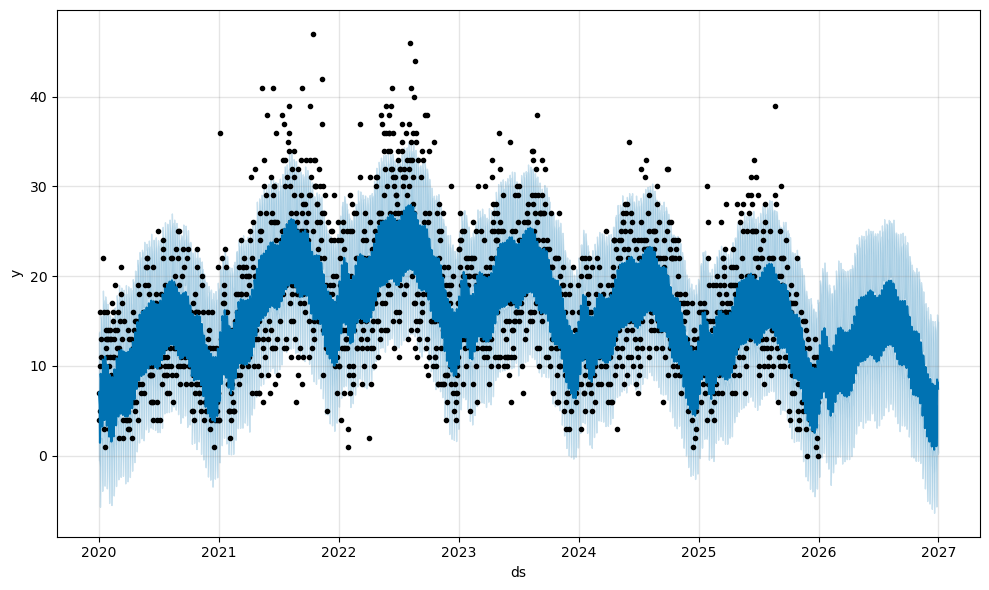

In [903]:
fig1 = m.plot(forecast)

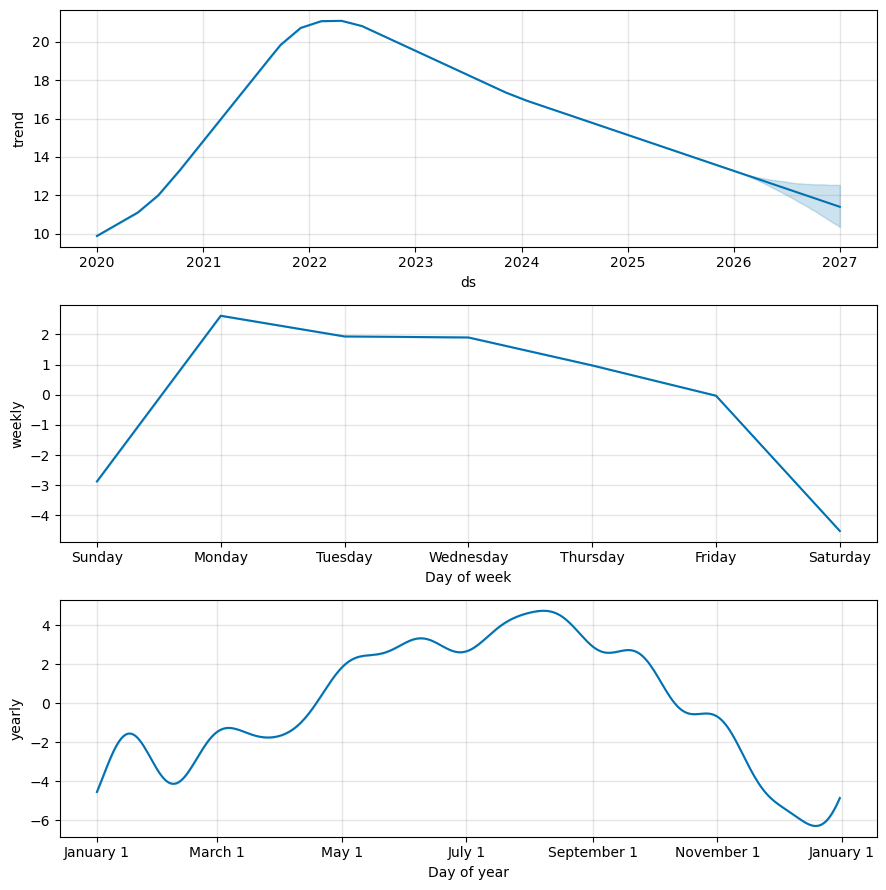

In [904]:
fig2 = m.plot_components(forecast)

In [905]:
# Python
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

## Cross validation

In [906]:
from prophet.diagnostics import cross_validation

In [907]:
df_cv = cross_validation(m, initial='730 days', period='7 days', horizon = '7 days')

  0%|          | 0/208 [00:00<?, ?it/s]

16:03:09 - cmdstanpy - INFO - Chain [1] start processing
16:03:09 - cmdstanpy - INFO - Chain [1] done processing
16:03:09 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1] done processing
16:03:10 - cmdstanpy - INFO - Chain [1] start processing
16:03:10 - cmdstanpy - INFO - Chain [1]

In [908]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-06,22.771892,15.755689,29.032774,24,2022-01-05
1,2022-01-07,21.637713,14.949140,28.306318,4,2022-01-05
2,2022-01-08,18.063914,11.104665,24.766765,14,2022-01-05
3,2022-01-09,20.311303,13.254306,26.934005,19,2022-01-05
4,2022-01-10,25.658200,18.971227,33.004084,19,2022-01-05
...,...,...,...,...,...,...
1451,2025-12-27,3.347870,-3.819192,10.005796,5,2025-12-24
1452,2025-12-28,5.180322,-1.356556,11.832257,2,2025-12-24
1453,2025-12-29,10.874214,4.120831,17.885943,6,2025-12-24
1454,2025-12-30,10.386134,3.552022,17.833505,10,2025-12-24


## Performance Metrics

In [909]:
from prophet.diagnostics import performance_metrics

In [910]:
df_p = performance_metrics(df_cv)

In [911]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,31.695800,5.629902,4.431388,0.199183,0.268579,0.798077
1,2 days,34.078711,5.837697,4.631830,0.227827,0.271698,0.750000
2,3 days,25.286175,5.028536,4.020384,0.268250,0.345969,0.855769
3,4 days,30.828196,5.552314,4.393341,0.285148,0.321546,0.817308
4,5 days,39.278998,6.267296,5.045096,0.212797,0.266388,0.769231
5,6 days,33.206295,5.762490,4.590586,0.214202,0.259640,0.774038
6,7 days,34.391302,5.864410,4.754012,0.209898,0.265234,0.783654


In [912]:
df_none = performance_metrics(df_cv, metrics=['rmse'], rolling_window=-1)

In [913]:
from prophet.diagnostics import register_performance_metric, rolling_mean_by_h
import numpy as np
@register_performance_metric
def mase(df, w):
    """Mean absolute scale error

        Parameters
        ----------
        df: Cross-validation results dataframe.
        w: Aggregation window size.

        Returns
        -------
        Dataframe with columns horizon and mase.
    """
    e = (df['y'] - df['yhat'])
    d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
    se = np.abs(e/d)
    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'mase': se})
    return rolling_mean_by_h(
        x=se.values, h=df['horizon'].values, w=w, name='mase'
    )

df_mase = performance_metrics(df_cv, metrics=['mase'])
df_mase.head()


,horizon,mase
0,1 days,0.619016
1,2 days,0.647015
2,3 days,0.561603
3,4 days,0.613701
4,5 days,0.704744


In [914]:
from prophet.plot import plot_cross_validation_metric

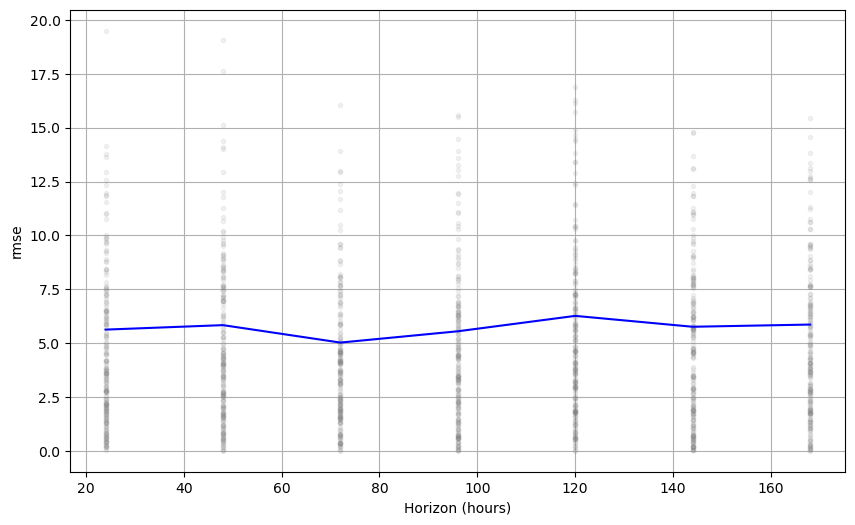

In [915]:
rolling_window=0.1
metric = 'rmse'
ax=None
figsize=(10, 6)
color='b'
point_color='gray'

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fig = ax.get_figure()
# Get the metric at the level of individual predictions, and with the rolling window.
df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

# Some work because matplotlib does not handle timedelta
# Target ~10 ticks.
tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
# Find the largest time resolution that has <1 unit per bin.
dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
dt_names = [
    'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
    'nanoseconds'
]
dt_conversions = [
    24 * 60 * 60 * 10 ** 9,
    60 * 60 * 10 ** 9,
    60 * 10 ** 9,
    10 ** 9,
    10 ** 6,
    10 ** 3,
    1.,
]
for i, dt in enumerate(dts):
    if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
        break

# x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
# x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

x_plt = df_none['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])
x_plt_h = df_h['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])

ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
ax.plot(x_plt_h, df_h[metric], '-', c=color)
ax.grid(True)

ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
ax.set_ylabel(metric)

plt.show()

In [916]:
# Python
import itertools
import numpy as np
import pandas as pd

cutoffs = pd.to_datetime(['2022-02-15', '2022-12-01', 
                          '2023-03-01', '2023-08-15', 
                          '2024-02-15', '2024-12-01', 
                          '2025-06-01'])

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

16:03:45 - cmdstanpy - INFO - Chain [1] start processing
16:03:45 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] start processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:47 - cmdstanpy - INFO - Chain [1] done processing
16:03:48 - cmdstanpy - INFO - Chain [1] start processing
16:03:48 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  7.859159
1                     0.001                     0.10  7.486321
2                     0.001                     1.00  7.527535
3                     0.001                    10.00  7.572632
4                     0.010                     0.01  6.268002
5                     0.010                     0.10  5.973052
6                     0.010                     1.00  5.943446
7                     0.010                    10.00  5.965785
8                     0.100                     0.01  5.563190
9                     0.100                     0.10  5.306949
10                    0.100                     1.00  5.313805
11                    0.100                    10.00  5.294607
12                    0.500                     0.01  5.702473
13                    0.500                     0.10  5.316364
14                    0.500                     1.00  5

16:04:23 - cmdstanpy - INFO - Chain [1] done processing
16:04:23 - cmdstanpy - INFO - Chain [1] done processing


In [917]:
best_params = all_params[np.argmin(rmses)]

print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


## Adding Rat Inspection Data as Additional Regressors

In [1154]:
regperiods = 30

cv_period = '7 days'

forecast_horizon = '7 days'

init_days = '1825 days'

In [1155]:
df = df_save

df

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


In [1156]:
path = r'../scr/data/cleaned_rat_inspection_data' 
all_files = glob.glob(os.path.join(path , "*.csv"))
df2 = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [1157]:
df2

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
0,Initial,11863635,PC6179277,1,1.008000e+09,800.0,25.0,119,WEST 24 STREET,10011.0,...,-73.993103,Manhattan,2012-08-10 10:51:54,Passed,08/20/2012 10:06:18 AM,4.0,3.0,91.0,1014981.0,Chelsea-Hudson Yards
1,Treatments,14251487,NaN,5484,3.008610e+09,861.0,49.0,271,60 STREET,11220.0,...,-74.021371,Brooklyn,2012-07-20 13:15:51,Monitoring visit,07/25/2012 08:02:30 AM,7.0,38.0,22.0,3016238.0,Sunset Park (West)
2,Initial,11821978,PC7142757,1,3.042460e+09,4246.0,36.0,290,FOUNTAIN AVENUE,11208.0,...,-73.874756,Brooklyn,2012-05-01 14:08:53,Passed,05/03/2012 10:08:51 AM,5.0,42.0,1194.0,3095334.0,East New York (North)
3,Treatments,14254353,NaN,6068,5.033490e+09,3349.0,50.0,137,REID AVENUE,10305.0,...,-74.083442,Staten Island,2012-11-30 10:27:49,Bait applied,12/03/2012 08:19:26 AM,2.0,50.0,7001.0,5049530.0,Grasmere-Arrochar-South Beach-Dongan Hills
4,Treatments,14254867,NaN,4944,2.028740e+09,2874.0,154.0,1401,NELSON AVENUE,10452.0,...,-73.922175,Bronx,2012-03-06 12:12:20,Bait applied,03/07/2012 11:44:33 AM,4.0,16.0,21302.0,2008782.0,Mount Eden-Claremont (West)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977661,Initial,13630210,PC8093866,1,1.005890e+09,589.0,45.0,7,CARMINE STREET,10014.0,...,-74.002042,Manhattan,2023-04-27 09:53:09,Passed,04/28/2023 09:33:18 AM,2.0,3.0,67.0,1010082.0,West Village
2977662,Initial,13579391,PC8043751,1,2.043770e+09,4377.0,16.0,2236,BOUCK AVENUE,10469.0,...,-73.850258,Bronx,2023-02-10 14:07:49,Passed,02/14/2023 10:59:50 AM,11.0,13.0,316.0,2050483.0,Pelham Gardens
2977663,Initial,13573073,PC8030979,1,2.042710e+09,4271.0,31.0,1911,HAIGHT AVENUE,10461.0,...,-73.854916,Bronx,2023-02-03 14:20:45,Passed,02/06/2023 09:02:16 AM,11.0,13.0,250.0,2048457.0,Morris Park
2977664,Initial,13652847,PC8117209,1,2.023760e+09,2376.0,125.0,439,EAST 154 STREET,10455.0,...,-73.914962,Bronx,2023-05-25 09:59:49,Passed,05/26/2023 08:26:33 AM,1.0,17.0,67.0,2113348.0,Melrose


In [1158]:
df2 = df2[df2['inspection_type']=='Initial']
df2.head(3)

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
0,Initial,11863635,PC6179277,1,1.008000e+09,800.0,25.0,119,WEST 24 STREET,10011.0,...,-73.993103,Manhattan,2012-08-10 10:51:54,Passed,08/20/2012 10:06:18 AM,4.0,3.0,91.0,1014981.0,Chelsea-Hudson Yards
2,Initial,11821978,PC7142757,1,3.042460e+09,4246.0,36.0,290,FOUNTAIN AVENUE,11208.0,...,-73.874756,Brooklyn,2012-05-01 14:08:53,Passed,05/03/2012 10:08:51 AM,5.0,42.0,1194.0,3095334.0,East New York (North)
5,Initial,11883158,PC6594748,1,2.027260e+09,2726.0,144.0,1093,SIMPSON STREET,10459.0,...,-73.892949,Bronx,2012-11-26 15:23:28,Passed,11/28/2012 03:17:10 PM,2.0,17.0,12701.0,2095291.0,Longwood


In [1159]:
df2['inspection_date'] = pd.to_datetime(df2['inspection_date']) 

In [1160]:
df2 = df2[df2['borough']=='Manhattan']

In [1161]:
df2.sample(3)

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
1304767,Initial,12135371,PC6354829,1,1.007430e+09,743.0,63.0,332,WEST 20 STREET,10011.0,...,-74.000931,Manhattan,2016-02-25 16:14:43,Passed,02/29/2016 02:45:05 PM,4.0,3.0,89.0,1013232.0,Chelsea-Hudson Yards
2133019,Initial,12586490,PC6463216,1,NaN,121.0,27.0,NaN,PARK ROW,10007.0,...,-74.004230,Manhattan,2019-04-02 10:30:41,Passed,04/03/2019 10:06:07 AM,NaN,NaN,NaN,NaN,NaN
973935,Initial,12337414,PC6360249,1,1.015190e+09,1519.0,45.0,162,EAST 91 STREET,10128.0,...,-73.952545,Manhattan,2017-09-29 10:11:37,Passed,10/03/2017 12:09:06 PM,8.0,5.0,14802.0,1048271.0,Upper East Side-Carnegie Hill


In [1162]:
df2= df2[['inspection_date', 'result']].copy()

In [1163]:
df2['result'].value_counts()

result
Passed                566065
Failed for Rat Act     58116
Rat Activity           41730
Failed for Other R     24578
Name: count, dtype: int64

In [1164]:
pp = df2.copy()

In [1165]:
pp.rename(columns={'inspection_date': 'date', 'result':'y'}, inplace=True)

In [1166]:
pp = pp[pp['date'] >= '2020-01-01']
pp = pp[pp['date'] <='2025-12-31']
pp['date'].describe()

count                        236067
mean     2023-07-25 21:35:00.783866
min             2020-01-02 09:28:04
25%             2022-06-06 14:33:49
50%             2023-08-25 13:20:37
75%      2024-10-04 08:00:06.500000
max             2025-12-30 14:35:14
Name: date, dtype: object

In [1167]:
pp = pp.copy()
pp["date"] = pd.to_datetime(pp["date"])
pp["ds"] = pp["date"].dt.date

pp = (
    pp.groupby("ds")
      .agg(
          total_entries=("y", "size"),
          non_passed=("y", lambda s: (s != "Passed").sum())
      )
      .assign(pct_non_passed=lambda d: d["non_passed"] / d["total_entries"] * 100)
      .reset_index()
      .sort_values("ds")
)

In [1168]:
pp

,ds,total_entries,non_passed,pct_non_passed
0,2020-01-02,242,34,14.049587
1,2020-01-03,290,41,14.137931
2,2020-01-06,118,35,29.661017
3,2020-01-07,61,38,62.295082
4,2020-01-08,49,24,48.979592
...,...,...,...,...
1557,2025-12-23,161,22,13.664596
1558,2025-12-24,138,22,15.942029
1559,2025-12-26,230,28,12.173913
1560,2025-12-29,257,33,12.840467


In [1169]:
# Ensure 'ds' column is datetime
pp['ds'] = pd.to_datetime(pp['ds'])

# Create full date range
full_dates = pd.date_range(start='2020-01-01', end='2025-12-31')

# Reindex the DataFrame to include all dates
pp = pp.set_index('ds').reindex(full_dates, fill_value=0).rename_axis('ds').reset_index()

# Optional: if you want to keep column order
pp = pp[['ds', 'total_entries', 'non_passed', 'pct_non_passed']]

pp

,ds,total_entries,non_passed,pct_non_passed
0,2020-01-01,0,0,0.000000
1,2020-01-02,242,34,14.049587
2,2020-01-03,290,41,14.137931
3,2020-01-04,0,0,0.000000
4,2020-01-05,0,0,0.000000
...,...,...,...,...
2187,2025-12-27,0,0,0.000000
2188,2025-12-28,0,0,0.000000
2189,2025-12-29,257,33,12.840467
2190,2025-12-30,230,22,9.565217


In [1170]:
df['total_inspect'] = pp['total_entries']
df['non_passed'] = pp['non_passed']
df['pct_non_passed'] = pp['pct_non_passed']

In [1171]:
df

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


In [1172]:
df['total_inspect'] = df['total_inspect'].fillna(0)
df['non_passed'] = df['non_passed'].fillna(0)
df['pct_non_passed'] = df['pct_non_passed'].fillna(0)

In [1173]:
# We will need to forecast the regressors so that we can use these forecasts for predictions

def forecast_regressor(df_reg, periods=30):
    """
    df_reg: DataFrame with columns ['ds', 'y'] for one regressor
    periods: number of days to forecast
    """
    m = Prophet()
    m.fit(df_reg)
    
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    
    # Return only the 'yhat' forecast column
    return forecast[['ds', 'yhat']]

# total_inspect
df_total_inspect = df[['ds', 'total_inspect']].rename(columns={'total_inspect': 'y'})
forecast_total_inspect = forecast_regressor(df_total_inspect, periods=regperiods)
forecast_total_inspect.rename(columns={'yhat': 'total_inspect'}, inplace=True)

# non_passed
df_non_passed = df[['ds', 'non_passed']].rename(columns={'non_passed': 'y'})
forecast_non_passed = forecast_regressor(df_non_passed, periods=regperiods)
forecast_non_passed.rename(columns={'yhat': 'non_passed'}, inplace=True)

# pct_non_passed
df_pct_non_passed = df[['ds', 'pct_non_passed']].rename(columns={'pct_non_passed': 'y'})
forecast_pct_non_passed = forecast_regressor(df_pct_non_passed, periods=regperiods)
forecast_pct_non_passed.rename(columns={'yhat': 'pct_non_passed'}, inplace=True)

# Build dataframe for the future.
future = df[['ds']].copy()  # only historical rows

16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing


In [1174]:
future

,ds
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
2187,2025-12-27
2188,2025-12-28
2189,2025-12-29
2190,2025-12-30


In [1175]:
# Create the future dates
future_dates = pd.DataFrame({'ds': pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=regperiods, freq='D')})

# Combine historical + future dates
future = pd.concat([future, future_dates], ignore_index=True)


# Add forecasts for inspections, nonpassed, nonpassing rates. 
future = future.merge(forecast_total_inspect, on='ds', how='left')
future = future.merge(forecast_non_passed, on='ds', how='left')
future = future.merge(forecast_pct_non_passed, on='ds', how='left')


# Fill old rows with correct values
future.loc[future['ds'] <= df['ds'].max(), 'total_inspect'] = df['total_inspect'].values
future.loc[future['ds'] <= df['ds'].max(), 'non_passed'] = df['non_passed'].values
future.loc[future['ds'] <= df['ds'].max(), 'pct_non_passed'] = df['pct_non_passed'].values

future

,ds,total_inspect,non_passed,pct_non_passed
0,2020-01-01,0.000000,0.000000,0.000000
1,2020-01-02,242.000000,34.000000,14.049587
2,2020-01-03,290.000000,41.000000,14.137931
3,2020-01-04,0.000000,0.000000,0.000000
4,2020-01-05,0.000000,0.000000,0.000000
...,...,...,...,...
2217,2026-01-26,158.708835,30.094826,22.535676
2218,2026-01-27,169.371381,33.798460,27.337011
2219,2026-01-28,177.238852,35.447072,25.380716
2220,2026-01-29,166.469195,32.461059,26.214298


Above, we should see that 'future' is a data frame with total_inspection, non_passed, and pct_non_passed filled in from 2020-01-01 to 2026-01-30.

We now want to fit this to the dataframe df which currently has '0' for for its rat_inspection data from 2024-04-11 onwards.

In [1176]:
df.iloc[1560::]

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
1560,2024-04-09,18,245,64,26.122449,37,24,64.864865,0
1561,2024-04-10,6,131,31,23.664122,21,13,61.904762,0
1562,2024-04-11,6,0,0,0.000000,0,0,0.000000,0
1563,2024-04-12,19,230,47,20.434783,39,25,64.102564,0
1564,2024-04-13,14,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing


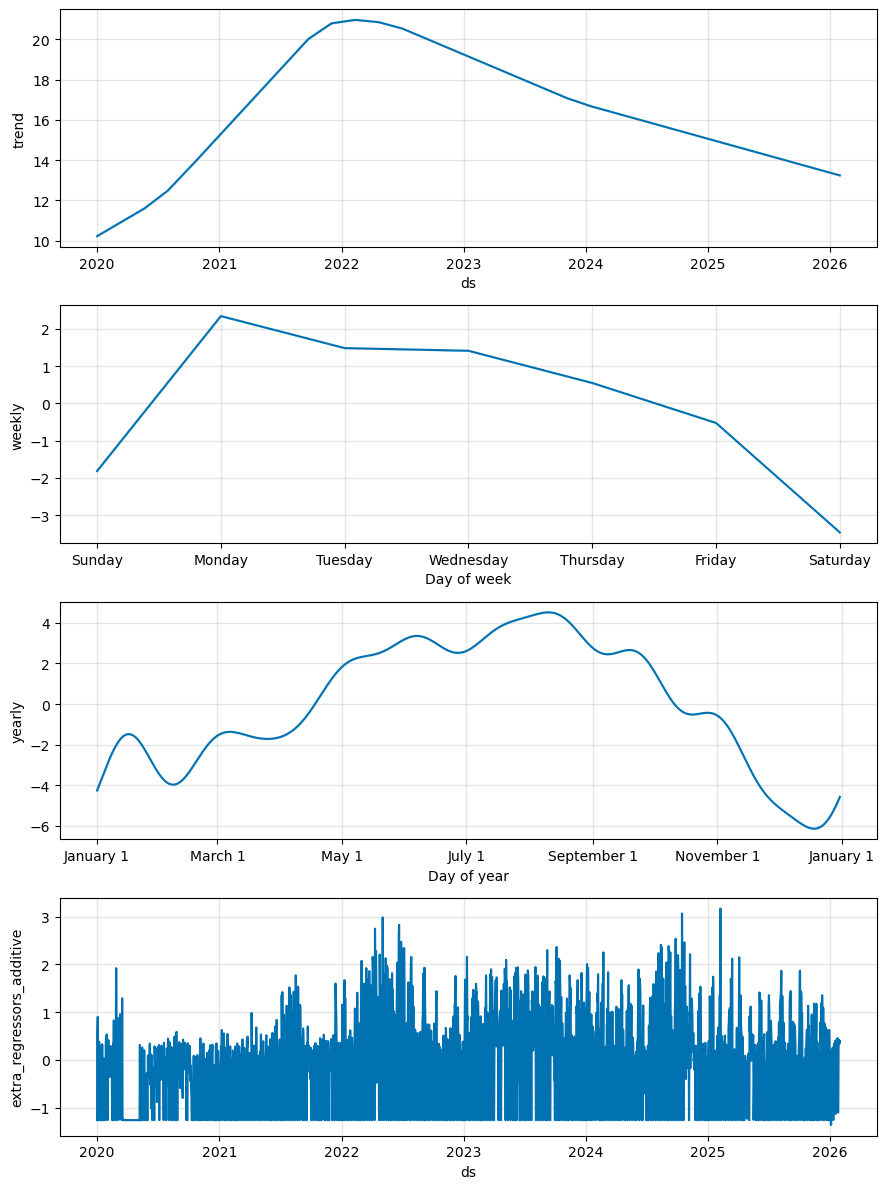

In [1177]:
# Forecasting with the regressors
m_main = Prophet()
m_main.add_regressor('total_inspect')
m_main.add_regressor('non_passed')
m_main.add_regressor('pct_non_passed')

m_main.fit(df)  # df has historical regressors

forecast_main = m_main.predict(future)

fig = m_main.plot_components(forecast_main)

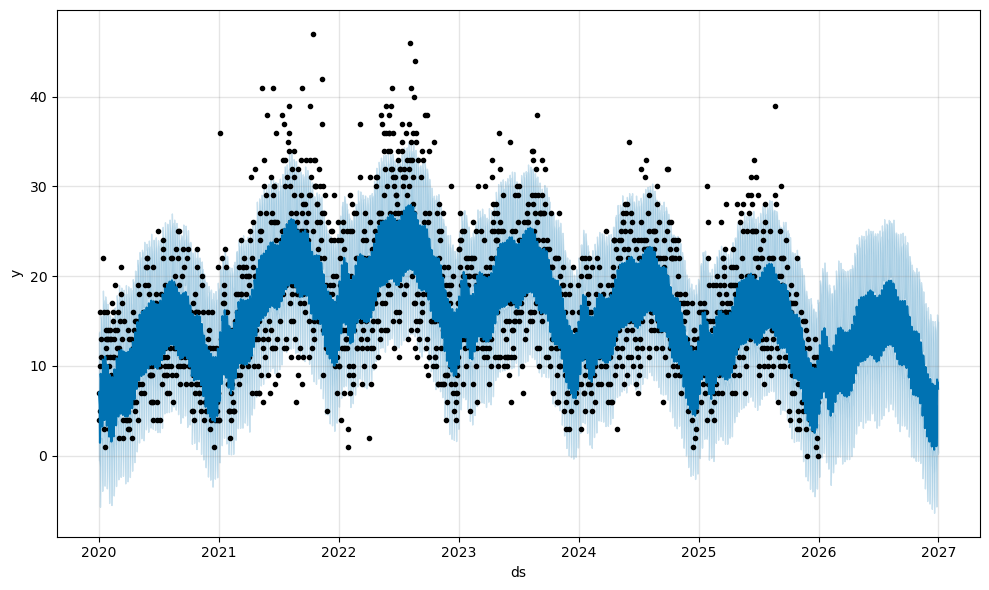

In [1178]:
fig1 = m_main.plot(forecast)

### CV Results for Additional Regressors

In [1179]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation: starts with initial number of days, testing periods are given, and we forecast by horizon
df_cv = cross_validation(m_main, initial=init_days, period=cv_period, horizon=forecast_horizon)
df_p = performance_metrics(df_cv)


print(df_p[['horizon', 'rmse']])

  0%|          | 0/52 [00:00<?, ?it/s]

16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1]

  horizon      rmse
0  1 days  5.692828
1  2 days  4.949453
2  3 days  3.920010
3  4 days  5.028255
4  5 days  5.615486
5  6 days  5.195893
6  7 days  5.852033


In [1180]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,32.408293,5.692828,4.455046,0.237074,0.331900,0.788462
1,2 days,24.497086,4.949453,4.032554,0.245656,0.272441,0.807692
2,3 days,15.366479,3.920010,3.225604,0.269887,0.324738,0.923077
3,4 days,25.283350,5.028255,4.021787,0.318002,0.368929,0.826923
4,5 days,31.533686,5.615486,4.555499,0.230262,0.279030,0.788462
5,6 days,26.997302,5.195893,4.117634,0.229372,0.282452,0.846154
6,7 days,34.246290,5.852033,4.656702,0.225367,0.329291,0.692308


In [1181]:
df_p1 = df_p

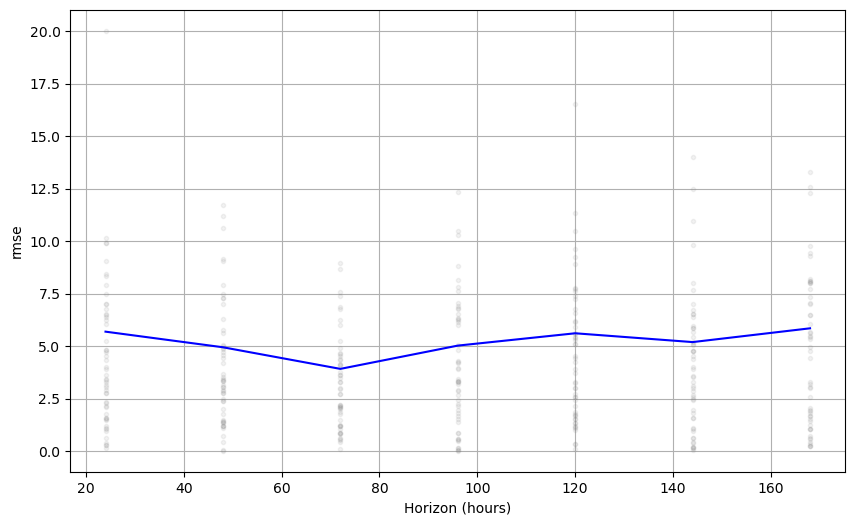

In [1182]:
rolling_window=0.1
metric = 'rmse'
ax=None
figsize=(10, 6)
color='b'
point_color='gray'

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fig = ax.get_figure()
# Get the metric at the level of individual predictions, and with the rolling window.
df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

# Some work because matplotlib does not handle timedelta
# Target ~10 ticks.
tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
# Find the largest time resolution that has <1 unit per bin.
dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
dt_names = [
    'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
    'nanoseconds'
]
dt_conversions = [
    24 * 60 * 60 * 10 ** 9,
    60 * 60 * 10 ** 9,
    60 * 10 ** 9,
    10 ** 9,
    10 ** 6,
    10 ** 3,
    1.,
]
for i, dt in enumerate(dts):
    if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
        break

# x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
# x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

x_plt = df_none['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])
x_plt_h = df_h['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])

ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
ax.plot(x_plt_h, df_h[metric], '-', c=color)
ax.grid(True)

ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
ax.set_ylabel(metric)

plt.show()

## Adding Compliance Rat Inspections as Regressors

to edit 

regperiods = 30

cv_period = '180 days'

forecast_horizon = '28 days'

init_days = '730 days'

go to the previous markdown block to change.

In [1183]:
df = df_save

df

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


In [1184]:
path = r'../scr/data/cleaned_rat_inspection_data' 
all_files = glob.glob(os.path.join(path , "*.csv"))
df2 = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [1185]:
df2 = df2[df2['inspection_type']=='Compliance']
df2

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
8,Compliance,12825729,PC7462628,2,4.131840e+09,13184.0,19.0,139-33,229 STREET,11413.0,...,-73.745816,Queens,2012-08-17 15:25:21,Passed,08/21/2012 09:55:54 AM,13.0,31.0,650.0,4283462.0,Laurelton
19,Compliance,12817118,PC6153951,2,1.019070e+09,1907.0,18.0,129,WEST 122 STREET,10027.0,...,-73.947886,Manhattan,2012-05-02 09:35:50,Failed for Other R,05/03/2012 11:52:27 AM,10.0,9.0,222.0,1057717.0,Harlem (South)
23,Compliance,12822000,PC6151759,2,1.015940e+09,1594.0,61.0,46,WEST 111 STREET,10026.0,...,-73.950269,Manhattan,2012-07-05 11:30:27,Passed,07/09/2012 12:33:24 PM,10.0,9.0,186.0,1051404.0,Harlem (South)
35,Compliance,12837150,PC7471822,2,4.127720e+09,12772.0,201.0,235-18,118 AVENUE,11411.0,...,-73.727643,Queens,2012-12-21 16:05:34,Failed for Other R,12/31/2012 12:25:05 PM,13.0,27.0,622.0,4275307.0,Cambria Heights
43,Compliance,12823491,PC6620296,2,2.034328e+09,3432.0,7501.0,105,FLEET COURT,10473.0,...,-73.852276,Bronx,2012-07-26 11:00:22,Passed,07/30/2012 08:30:34 AM,9.0,18.0,4.0,2124347.0,Soundview-Clason Point
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977636,Compliance,13583051,PC7999786,2,2.028440e+09,2844.0,43.0,1466,TOWNSEND AVENUE,10452.0,...,-73.915725,Bronx,2023-02-16 15:40:08,Passed,02/17/2023 03:54:40 PM,4.0,16.0,223.0,2008113.0,Mount Eden-Claremont (West)
2977645,Compliance,13589546,PC8024498,2,3.032570e+09,3257.0,22.0,194,STOCKHOLM STREET,11237.0,...,-73.922191,Brooklyn,2023-02-28 15:53:46,Rat Activity,03/01/2023 01:55:51 PM,4.0,37.0,431.0,3074142.0,Bushwick (West)
2977655,Compliance,13742320,PC8137404,2,1.018960e+09,1896.0,65.0,2941,BROADWAY,10025.0,...,-73.964325,Manhattan,2023-10-24 10:40:42,Rat Activity,10/27/2023 09:25:14 AM,9.0,7.0,205.0,1057379.0,Morningside Heights
2977658,Compliance,13685265,PC8119033,2,4.140480e+09,14048.0,83.0,161-50,CROSS BAY BOULEVARD,11414.0,...,-73.838850,Queens,2023-07-20 16:05:36,Passed,07/24/2023 12:34:03 PM,10.0,32.0,89201.0,4294016.0,Howard Beach-Lindenwood


In [1186]:
df2['inspection_date'] = pd.to_datetime(df2['inspection_date']) 

In [1187]:
df2 = df2[df2['borough']=='Manhattan']
df2

,inspection_type,job_ticket_or_work_order_id,job_id,job_progress,bbl,block,lot,house_number,street_name,zip_code,...,longitude,borough,inspection_date,result,approved_date,community_board,council_district,census_tract,bin,nta
19,Compliance,12817118,PC6153951,2,1.019070e+09,1907.0,18.0,129,WEST 122 STREET,10027.0,...,-73.947886,Manhattan,2012-05-02 09:35:50,Failed for Other R,05/03/2012 11:52:27 AM,10.0,9.0,222.0,1057717.0,Harlem (South)
23,Compliance,12822000,PC6151759,2,1.015940e+09,1594.0,61.0,46,WEST 111 STREET,10026.0,...,-73.950269,Manhattan,2012-07-05 11:30:27,Passed,07/09/2012 12:33:24 PM,10.0,9.0,186.0,1051404.0,Harlem (South)
51,Compliance,12837384,PC7534196,1,1.001470e+09,147.0,9.0,145,DUANE STREET,10013.0,...,-74.008016,Manhattan,2012-12-31 13:14:16,Passed,01/02/2013 01:04:47 PM,1.0,1.0,33.0,1001609.0,Tribeca-Civic Center
176,Compliance,12811092,PC6103884,2,1.007710e+09,771.0,74.0,234,8 AVENUE,10011.0,...,-73.999029,Manhattan,2012-02-14 16:55:46,Passed,02/22/2012 05:08:56 PM,4.0,3.0,87.0,1014098.0,Chelsea-Hudson Yards
239,Compliance,12821465,PC6199908,2,1.002980e+09,298.0,18.0,56,HESTER STREET,10002.0,...,-73.990765,Manhattan,2012-06-25 10:29:58,Passed,06/29/2012 10:11:41 AM,3.0,1.0,16.0,1084870.0,Chinatown-Two Bridges
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2977561,Compliance,13553732,PC8004014,2,1.002880e+09,288.0,47.0,503,GRAND STREET,10002.0,...,-73.982339,Manhattan,2023-01-05 13:41:15,Passed,01/10/2023 03:22:24 PM,3.0,1.0,202.0,1003751.0,Lower East Side
2977569,Compliance,13556895,PC7923058,2,1.018810e+09,1881.0,15.0,235,WEST 109 STREET,10025.0,...,-73.965628,Manhattan,2023-01-10 13:07:32,Passed,01/23/2023 09:44:58 AM,7.0,7.0,195.0,1056702.0,Upper West Side-Manhattan Valley
2977610,Compliance,13677013,PC8118530,2,1.004828e+09,482.0,7503.0,430,BROOME STREET,10013.0,...,-73.998900,Manhattan,2023-07-06 14:05:00,Passed,07/07/2023 08:53:23 AM,2.0,1.0,45.0,1007226.0,SoHo-Little Italy-Hudson Square
2977632,Compliance,13599444,PC7904105,2,1.010390e+09,1039.0,47.0,322,WEST 49 STREET,10019.0,...,-73.987694,Manhattan,2023-03-14 11:42:37,Rat Activity,03/16/2023 10:15:07 AM,4.0,3.0,127.0,1025151.0,Hell's Kitchen


In [1188]:
df2= df2[['inspection_date', 'result']].copy()

In [1189]:
df2['result'].value_counts()

result
Passed                47930
Failed for Rat Act    29969
Rat Activity          22306
Failed for Other R     7850
Name: count, dtype: int64

In [1190]:
pp2 = df2.copy()

In [1191]:
pp2.rename(columns={'inspection_date': 'date', 'result':'y'}, inplace=True)

In [1192]:
pp2 = pp2[pp2['date'] >= '2020-01-01']
pp2 = pp2[pp2['date'] <='2025-12-31']
pp2['date'].describe()

count                         52877
mean     2023-08-09 22:21:04.630973
min             2020-01-02 10:25:49
25%             2022-06-17 10:00:31
50%             2023-09-19 11:30:45
75%             2024-11-04 12:08:18
max             2025-12-30 14:17:33
Name: date, dtype: object

In [1193]:
pp2 = pp2.copy()
pp2["date"] = pd.to_datetime(pp2["date"])
pp2["ds"] = pp2["date"].dt.date

pp2 = (
    pp2.groupby("ds")
      .agg(
          comp_total_entries=("y", "size"),
          comp_non_passed=("y", lambda s: (s != "Passed").sum())
      )
      .assign(comp_pct_non_passed=lambda d: d["comp_non_passed"] / d["comp_total_entries"] * 100)
      .reset_index()
      .sort_values("ds")
)

In [1194]:
pp2

,ds,comp_total_entries,comp_non_passed,comp_pct_non_passed
0,2020-01-02,45,33,73.333333
1,2020-01-03,68,32,47.058824
2,2020-01-06,35,24,68.571429
3,2020-01-07,82,44,53.658537
4,2020-01-08,63,39,61.904762
...,...,...,...,...
1387,2025-12-23,33,20,60.606061
1388,2025-12-24,33,23,69.696970
1389,2025-12-26,4,4,100.000000
1390,2025-12-29,36,21,58.333333


In [1195]:
# Ensure 'ds' column is datetime
pp2['ds'] = pd.to_datetime(pp2['ds'])

# Create full date range
full_dates = pd.date_range(start='2020-01-01', end='2025-12-31')

# Reindex the DataFrame to include all dates
pp2 = pp2.set_index('ds').reindex(full_dates, fill_value=0).rename_axis('ds').reset_index()

# Optional: if you want to keep column order
pp2 = pp2[['ds', 'comp_total_entries', 'comp_non_passed', 'comp_pct_non_passed']]

pp2

,ds,comp_total_entries,comp_non_passed,comp_pct_non_passed
0,2020-01-01,0,0,0.000000
1,2020-01-02,45,33,73.333333
2,2020-01-03,68,32,47.058824
3,2020-01-04,0,0,0.000000
4,2020-01-05,0,0,0.000000
...,...,...,...,...
2187,2025-12-27,0,0,0.000000
2188,2025-12-28,0,0,0.000000
2189,2025-12-29,36,21,58.333333
2190,2025-12-30,43,30,69.767442


In [1196]:
df['comp_total_inspect'] = pp2['comp_total_entries']
df['comp_non_passed'] = pp2['comp_non_passed']
df['comp_pct_non_passed'] = pp2['comp_pct_non_passed']

In [1197]:
df

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


In [1198]:
df['total_inspect'] = df['total_inspect'].fillna(0)
df['non_passed'] = df['non_passed'].fillna(0)
df['pct_non_passed'] = df['pct_non_passed'].fillna(0)

In [1199]:
# We will need to forecast the regressors so that we can use these forecasts for predictions

def forecast_regressor(df_reg, periods=30):
    """
    df_reg: DataFrame with columns ['ds', 'y'] for one regressor
    periods: number of days to forecast
    """
    m = Prophet()
    m.fit(df_reg)
    
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future)
    
    # Return only the 'yhat' forecast column
    return forecast[['ds', 'yhat']]

# total_inspect
df_total_inspect = df[['ds', 'total_inspect']].rename(columns={'total_inspect': 'y'})
forecast_total_inspect = forecast_regressor(df_total_inspect, periods=regperiods)
forecast_total_inspect.rename(columns={'yhat': 'total_inspect'}, inplace=True)

# non_passed
df_non_passed = df[['ds', 'non_passed']].rename(columns={'non_passed': 'y'})
forecast_non_passed = forecast_regressor(df_non_passed, periods=regperiods)
forecast_non_passed.rename(columns={'yhat': 'non_passed'}, inplace=True)

# pct_non_passed
df_pct_non_passed = df[['ds', 'pct_non_passed']].rename(columns={'pct_non_passed': 'y'})
forecast_pct_non_passed = forecast_regressor(df_pct_non_passed, periods=regperiods)
forecast_pct_non_passed.rename(columns={'yhat': 'pct_non_passed'}, inplace=True)

# comp_total_inspect
df_comp_total_inspect = df[['ds', 'comp_total_inspect']].rename(columns={'comp_total_inspect': 'y'})
forecast_comp_total_inspect = forecast_regressor(df_comp_total_inspect, periods=regperiods)
forecast_comp_total_inspect.rename(columns={'yhat': 'comp_total_inspect'}, inplace=True)

# comp_non_passed
df_comp_non_passed = df[['ds', 'comp_non_passed']].rename(columns={'comp_non_passed': 'y'})
forecast_comp_non_passed = forecast_regressor(df_comp_non_passed, periods=regperiods)
forecast_comp_non_passed.rename(columns={'yhat': 'comp_non_passed'}, inplace=True)

# comp_pct_non_passed
df_comp_pct_non_passed = df[['ds', 'comp_pct_non_passed']].rename(columns={'comp_pct_non_passed': 'y'})
forecast_comp_pct_non_passed = forecast_regressor(df_pct_non_passed, periods=regperiods)
forecast_comp_pct_non_passed.rename(columns={'yhat': 'comp_pct_non_passed'}, inplace=True)


# Build dataframe for the future.
future = df[['ds']].copy()  # only historical rows

16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing


In [1200]:
future

,ds
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
2187,2025-12-27
2188,2025-12-28
2189,2025-12-29
2190,2025-12-30


In [1201]:
# Create the future dates
future_dates = pd.DataFrame({'ds': pd.date_range(start=df['ds'].max() + pd.Timedelta(days=1), periods=regperiods, freq='D')})

# Combine historical + future dates
future = pd.concat([future, future_dates], ignore_index=True)


# Add forecasts for inspections, nonpassed, nonpassing rates. 
future = future.merge(forecast_total_inspect, on='ds', how='left')
future = future.merge(forecast_non_passed, on='ds', how='left')
future = future.merge(forecast_pct_non_passed, on='ds', how='left')
future = future.merge(forecast_comp_total_inspect, on='ds', how='left')
future = future.merge(forecast_comp_non_passed, on='ds', how='left')
future = future.merge(forecast_comp_pct_non_passed, on='ds', how='left')


# Fill old rows with correct values
future.loc[future['ds'] <= df['ds'].max(), 'total_inspect'] = df['total_inspect'].values
future.loc[future['ds'] <= df['ds'].max(), 'non_passed'] = df['non_passed'].values
future.loc[future['ds'] <= df['ds'].max(), 'pct_non_passed'] = df['pct_non_passed'].values
future.loc[future['ds'] <= df['ds'].max(), 'comp_total_inspect'] = df['comp_total_inspect'].values
future.loc[future['ds'] <= df['ds'].max(), 'comp_non_passed'] = df['comp_non_passed'].values
future.loc[future['ds'] <= df['ds'].max(), 'comp_pct_non_passed'] = df['comp_pct_non_passed'].values

future

,ds,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed
0,2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-01-02,242.000000,34.000000,14.049587,45.000000,33.000000,73.333333
2,2020-01-03,290.000000,41.000000,14.137931,68.000000,32.000000,47.058824
3,2020-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-01-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2217,2026-01-26,158.708835,30.094826,22.535676,34.283882,21.316480,22.535676
2218,2026-01-27,169.371381,33.798460,27.337011,38.008611,23.621583,27.337011
2219,2026-01-28,177.238852,35.447072,25.380716,39.645013,25.190593,25.380716
2220,2026-01-29,166.469195,32.461059,26.214298,37.382696,23.446398,26.214298


Above, we should see that 'future' is a data frame with total_inspection, non_passed, and pct_non_passed filled in from 2020-01-01 to 2026-01-30.

We now want to fit this to the dataframe df which currently has '0' for for its rat_inspection data from 2024-04-11 onwards.

In [1202]:
df.iloc[1560::]

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
1560,2024-04-09,18,245,64,26.122449,37,24,64.864865,0
1561,2024-04-10,6,131,31,23.664122,21,13,61.904762,0
1562,2024-04-11,6,0,0,0.000000,0,0,0.000000,0
1563,2024-04-12,19,230,47,20.434783,39,25,64.102564,0
1564,2024-04-13,14,0,0,0.000000,0,0,0.000000,1
...,...,...,...,...,...,...,...,...,...
2187,2025-12-27,5,0,0,0.000000,0,0,0.000000,1
2188,2025-12-28,2,0,0,0.000000,0,0,0.000000,1
2189,2025-12-29,6,257,33,12.840467,36,21,58.333333,0
2190,2025-12-30,10,230,22,9.565217,43,30,69.767442,0


16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing


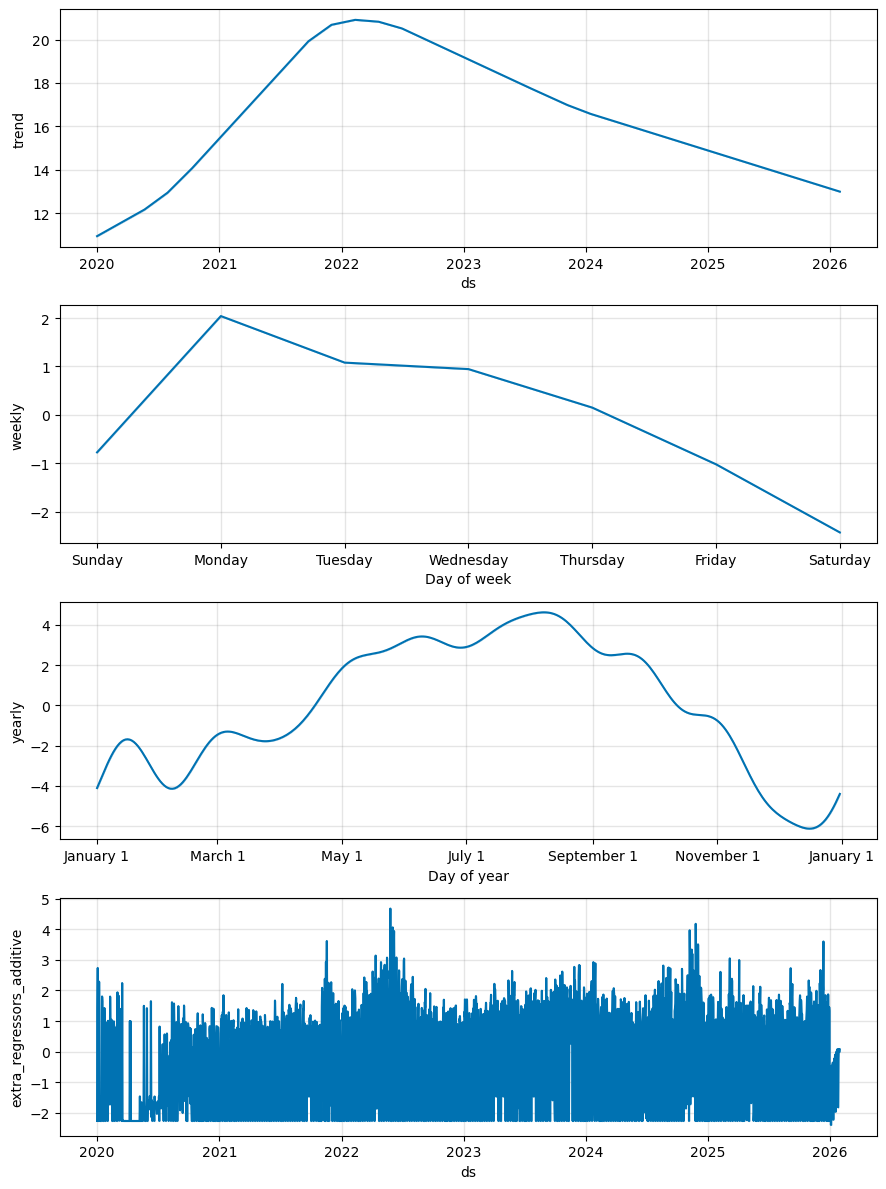

In [1203]:
# Forecasting with the regressors
m_main = Prophet()
m_main.add_regressor('total_inspect')
m_main.add_regressor('non_passed')
m_main.add_regressor('pct_non_passed')
m_main.add_regressor('comp_total_inspect')
m_main.add_regressor('comp_non_passed')
m_main.add_regressor('comp_pct_non_passed')

m_main.fit(df)  # df has historical regressors

forecast_main = m_main.predict(future)

fig = m_main.plot_components(forecast_main)

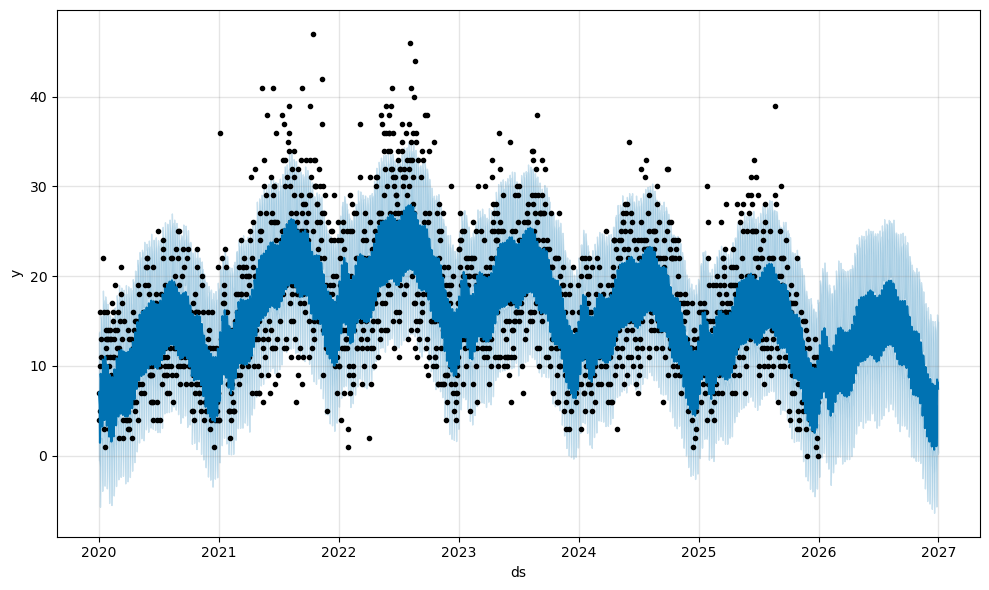

In [1204]:
fig1 = m_main.plot(forecast)

### CV Results for Additional Regressors

In [1205]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation: starts with initial number of days, testing periods are given, and we forecast by horizon
df_cv = cross_validation(m_main, initial=init_days, period=cv_period, horizon=forecast_horizon)
df_p = performance_metrics(df_cv)


print(df_p[['horizon', 'rmse']])

  0%|          | 0/52 [00:00<?, ?it/s]

16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1]

  horizon      rmse
0  1 days  5.610880
1  2 days  4.872223
2  3 days  3.993268
3  4 days  4.976020
4  5 days  5.394922
5  6 days  5.156698
6  7 days  5.838038


In [1206]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,31.481974,5.610880,4.403566,0.214421,0.329235,0.807692
1,2 days,23.738556,4.872223,4.001865,0.243474,0.270060,0.826923
2,3 days,15.946185,3.993268,3.313927,0.284322,0.341239,0.923077
3,4 days,24.760779,4.976020,4.017857,0.325332,0.371609,0.846154
4,5 days,29.105179,5.394922,4.325405,0.210467,0.263773,0.788462
5,6 days,26.591530,5.156698,4.097536,0.211961,0.280541,0.846154
6,7 days,34.082685,5.838038,4.665405,0.234552,0.333826,0.692308


In [1207]:
df_p2 = df_p

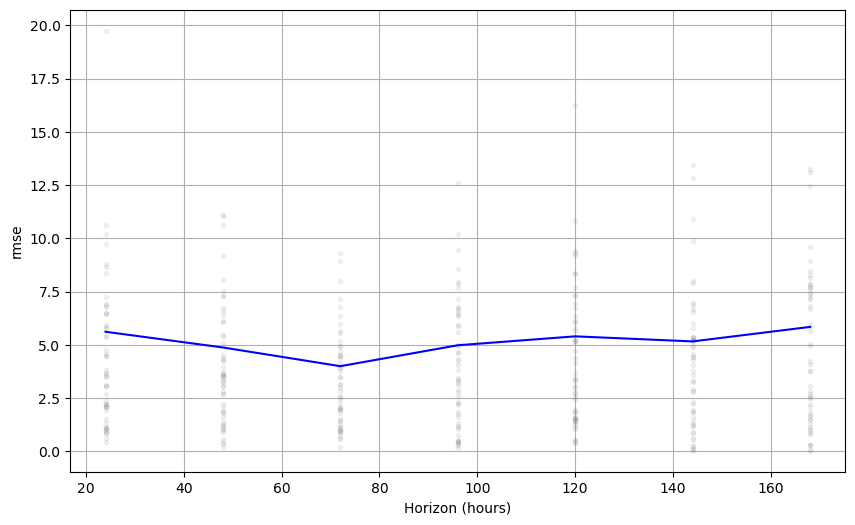

In [1208]:
rolling_window=0.1
metric = 'rmse'
ax=None
figsize=(10, 6)
color='b'
point_color='gray'

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fig = ax.get_figure()
# Get the metric at the level of individual predictions, and with the rolling window.
df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

# Some work because matplotlib does not handle timedelta
# Target ~10 ticks.
tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
# Find the largest time resolution that has <1 unit per bin.
dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
dt_names = [
    'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
    'nanoseconds'
]
dt_conversions = [
    24 * 60 * 60 * 10 ** 9,
    60 * 60 * 10 ** 9,
    60 * 10 ** 9,
    10 ** 9,
    10 ** 6,
    10 ** 3,
    1.,
]
for i, dt in enumerate(dts):
    if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
        break

# x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
# x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

x_plt = df_none['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])
x_plt_h = df_h['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])

ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
ax.plot(x_plt_h, df_h[metric], '-', c=color)
ax.grid(True)

ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
ax.set_ylabel(metric)

plt.show()

In [1209]:
df.head(20)

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
5,2020-01-06,13,118,35,29.661017,35,24,68.571429,0
6,2020-01-07,11,61,38,62.295082,82,44,53.658537,0
7,2020-01-08,7,49,24,48.979592,63,39,61.904762,0
8,2020-01-09,6,0,0,0.000000,0,0,0.000000,0
9,2020-01-10,7,0,0,0.000000,0,0,0.000000,0


## Adding Weekends?

Due to the nature of the inspections data, one might need to also factor in the effects of weekends and holidays.

16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing


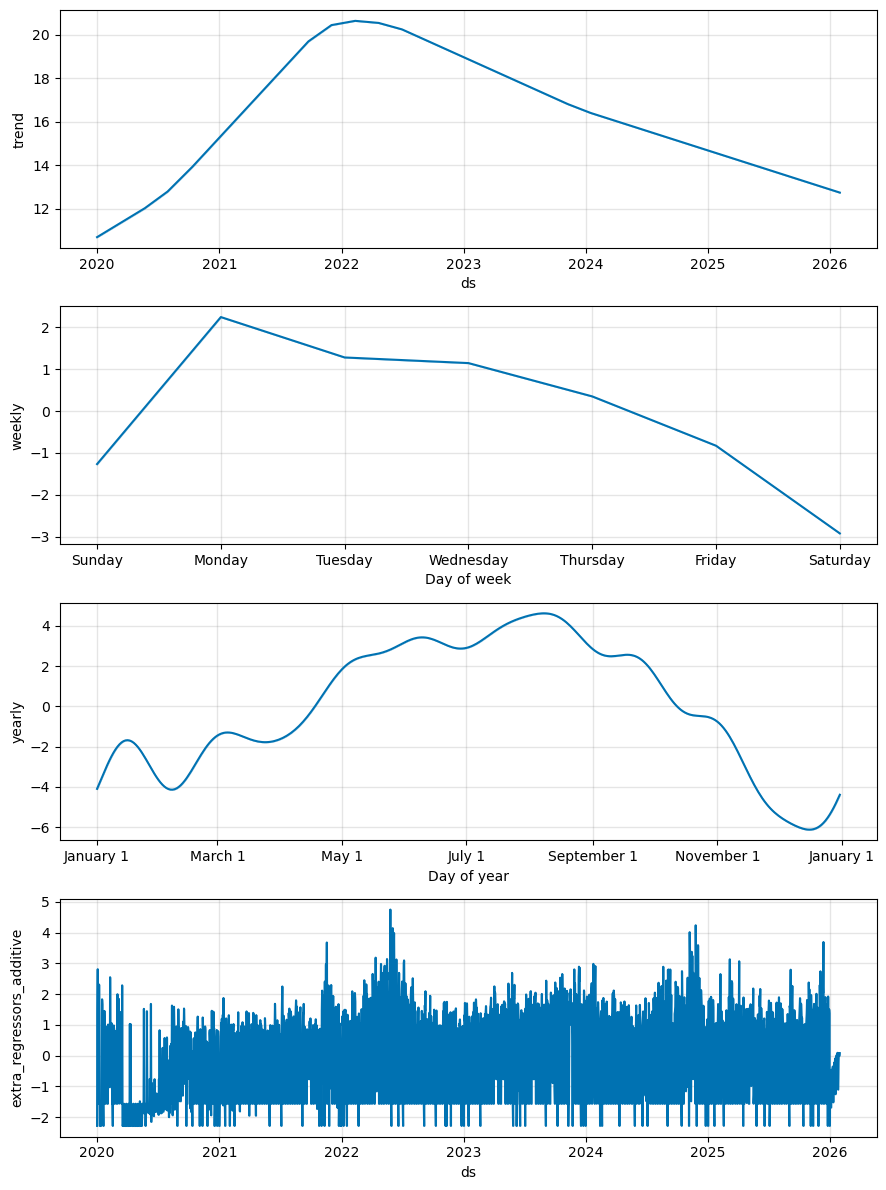

In [1210]:
import pandas as pd
from prophet import Prophet

# Create a weekend indicator
df['is_weekend'] = df['ds'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

# Add the weekend regressor
m_main = Prophet()
m_main.add_regressor('total_inspect')
m_main.add_regressor('non_passed')
m_main.add_regressor('pct_non_passed')
m_main.add_regressor('comp_total_inspect')
m_main.add_regressor('comp_non_passed')
m_main.add_regressor('comp_pct_non_passed')
m_main.add_regressor('is_weekend')  # new regressor

m_main.fit(df)

# Make sure the future dataframe also has the weekend indicator
future['is_weekend'] = future['ds'].dt.dayofweek.apply(lambda x: 1 if x >= 5 else 0)

forecast_main = m_main.predict(future)

fig = m_main.plot_components(forecast_main)

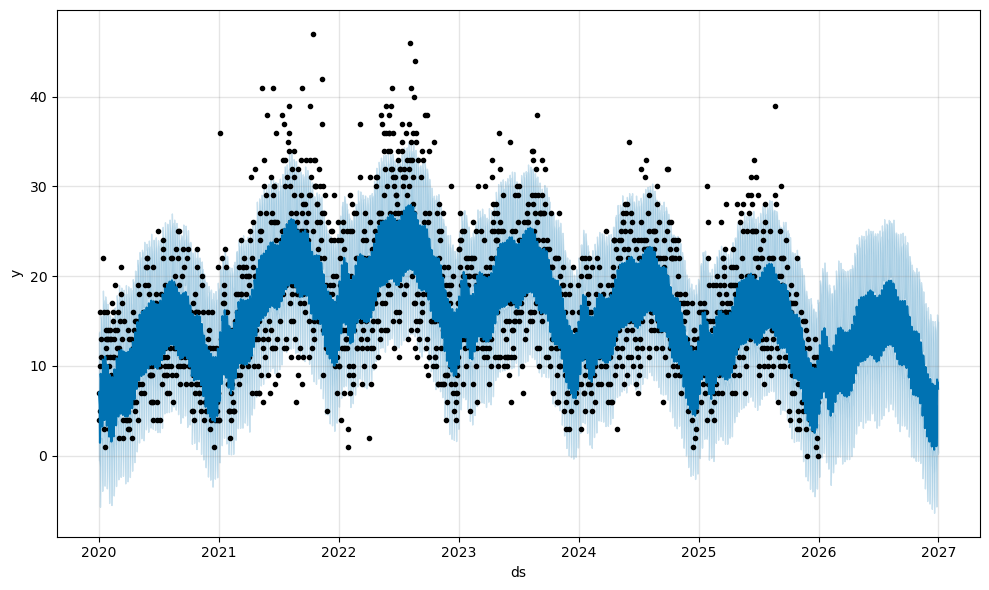

In [1211]:
fig1 = m_main.plot(forecast)

### CV Results for Additional Regressors

In [1212]:
from prophet.diagnostics import cross_validation, performance_metrics

# Cross-validation: starts with initial number of days, testing periods are given, and we forecast by horizon
df_cv = cross_validation(m_main, initial=init_days, period=cv_period, horizon=forecast_horizon)
df_p = performance_metrics(df_cv)


print(df_p[['horizon', 'rmse']])

  0%|          | 0/52 [00:00<?, ?it/s]

16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1]

  horizon      rmse
0  1 days  5.613135
1  2 days  4.870011
2  3 days  3.997288
3  4 days  4.977132
4  5 days  5.398605
5  6 days  5.165920
6  7 days  5.846423


In [1213]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,31.507280,5.613135,4.402747,0.211027,0.329105,0.826923
1,2 days,23.717009,4.870011,4.001390,0.242447,0.270014,0.826923
2,3 days,15.978308,3.997288,3.310454,0.290203,0.340795,0.923077
3,4 days,24.771842,4.977132,4.022136,0.325967,0.372300,0.807692
4,5 days,29.144940,5.398605,4.328292,0.209470,0.263984,0.788462
5,6 days,26.686726,5.165920,4.103490,0.212230,0.280934,0.884615
6,7 days,34.180665,5.846423,4.671575,0.236930,0.334092,0.673077


In [1214]:
df_p3 = df_p

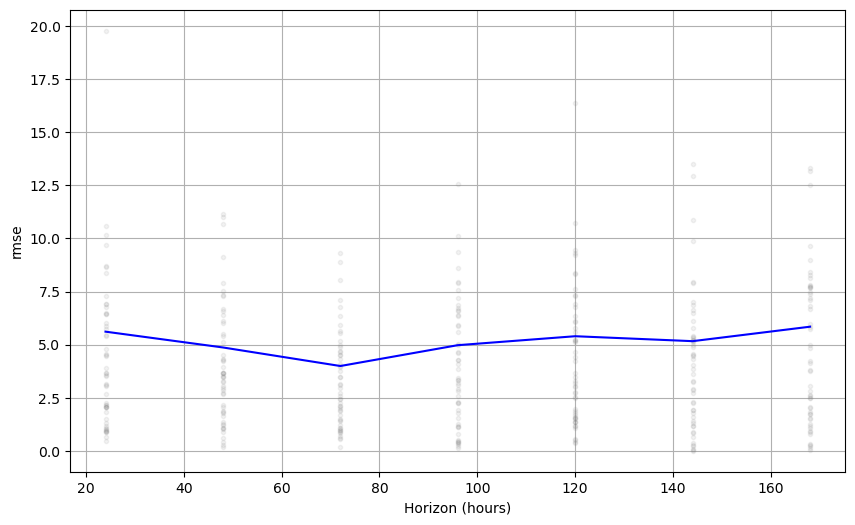

In [1215]:
rolling_window=0.1
metric = 'rmse'
ax=None
figsize=(10, 6)
color='b'
point_color='gray'

fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.add_subplot(111)

fig = ax.get_figure()
# Get the metric at the level of individual predictions, and with the rolling window.
df_none = performance_metrics(df_cv, metrics=[metric], rolling_window=-1)
df_h = performance_metrics(df_cv, metrics=[metric], rolling_window=rolling_window)

# Some work because matplotlib does not handle timedelta
# Target ~10 ticks.
tick_w = max(df_none['horizon'].astype('timedelta64[ns]')) / 10.
# Find the largest time resolution that has <1 unit per bin.
dts = ['D', 'h', 'm', 's', 'ms', 'us', 'ns']
dt_names = [
    'days', 'hours', 'minutes', 'seconds', 'milliseconds', 'microseconds',
    'nanoseconds'
]
dt_conversions = [
    24 * 60 * 60 * 10 ** 9,
    60 * 60 * 10 ** 9,
    60 * 10 ** 9,
    10 ** 9,
    10 ** 6,
    10 ** 3,
    1.,
]
for i, dt in enumerate(dts):
    if np.timedelta64(1, dt) < np.timedelta64(tick_w, 'ns'):
        break

# x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
# x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])

x_plt = df_none['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])
x_plt_h = df_h['horizon'].astype('timedelta64[ns]').to_numpy().view(np.int64) / float(dt_conversions[i])

ax.plot(x_plt, df_none[metric], '.', alpha=0.1, c=point_color)
ax.plot(x_plt_h, df_h[metric], '-', c=color)
ax.grid(True)

ax.set_xlabel('Horizon ({})'.format(dt_names[i]))
ax.set_ylabel(metric)

plt.show()

In [1216]:
df.head(20)

,ds,y,total_inspect,non_passed,pct_non_passed,comp_total_inspect,comp_non_passed,comp_pct_non_passed,is_weekend
0,2020-01-01,4,0,0,0.000000,0,0,0.000000,0
1,2020-01-02,7,242,34,14.049587,45,33,73.333333,0
2,2020-01-03,16,290,41,14.137931,68,32,47.058824,0
3,2020-01-04,10,0,0,0.000000,0,0,0.000000,1
4,2020-01-05,5,0,0,0.000000,0,0,0.000000,1
5,2020-01-06,13,118,35,29.661017,35,24,68.571429,0
6,2020-01-07,11,61,38,62.295082,82,44,53.658537,0
7,2020-01-08,7,49,24,48.979592,63,39,61.904762,0
8,2020-01-09,6,0,0,0.000000,0,0,0.000000,0
9,2020-01-10,7,0,0,0.000000,0,0,0.000000,0


## Last comparisons

df_p is just by rat sightings

df_p1 uses rat sightings + rat inspection initial data

df_p2 uses rat sightings + rat inspection initial data + rat compliance data

df_p3 uses rat sightings + rat inspection initial data + rat compliance data + weekend


In [1217]:
df_p1 

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,32.408293,5.692828,4.455046,0.237074,0.331900,0.788462
1,2 days,24.497086,4.949453,4.032554,0.245656,0.272441,0.807692
2,3 days,15.366479,3.920010,3.225604,0.269887,0.324738,0.923077
3,4 days,25.283350,5.028255,4.021787,0.318002,0.368929,0.826923
4,5 days,31.533686,5.615486,4.555499,0.230262,0.279030,0.788462
5,6 days,26.997302,5.195893,4.117634,0.229372,0.282452,0.846154
6,7 days,34.246290,5.852033,4.656702,0.225367,0.329291,0.692308


In [1218]:
df_p2

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,31.481974,5.610880,4.403566,0.214421,0.329235,0.807692
1,2 days,23.738556,4.872223,4.001865,0.243474,0.270060,0.826923
2,3 days,15.946185,3.993268,3.313927,0.284322,0.341239,0.923077
3,4 days,24.760779,4.976020,4.017857,0.325332,0.371609,0.846154
4,5 days,29.105179,5.394922,4.325405,0.210467,0.263773,0.788462
5,6 days,26.591530,5.156698,4.097536,0.211961,0.280541,0.846154
6,7 days,34.082685,5.838038,4.665405,0.234552,0.333826,0.692308


In [1219]:
df_p3 

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,31.507280,5.613135,4.402747,0.211027,0.329105,0.826923
1,2 days,23.717009,4.870011,4.001390,0.242447,0.270014,0.826923
2,3 days,15.978308,3.997288,3.310454,0.290203,0.340795,0.923077
3,4 days,24.771842,4.977132,4.022136,0.325967,0.372300,0.807692
4,5 days,29.144940,5.398605,4.328292,0.209470,0.263984,0.788462
5,6 days,26.686726,5.165920,4.103490,0.212230,0.280934,0.884615
6,7 days,34.180665,5.846423,4.671575,0.236930,0.334092,0.673077


In [1220]:
import pandas as pd

# Your DataFrames
dfs = [df_p1, df_p2, df_p3]
names = ['df_p1', 'df_p2', 'df_p3']

# Numeric columns to compare
numeric_cols = ['mse', 'rmse', 'mae', 'mdape', 'smape', 'coverage']

# Create a single DataFrame to store which df has the minimum
min_table = pd.DataFrame(index=df_p1.index, columns=numeric_cols)

for col in numeric_cols:
    # Stack the values for this column across all dataframes
    stacked = pd.concat([df[col] for df in dfs], axis=1)
    stacked.columns = names
    # Find which column has the min for each row
    min_table[col] = stacked.idxmin(axis=1)

min_table['horizon'] = df_p1['horizon']
min_table = min_table[['horizon'] + numeric_cols]

min_table

,horizon,mse,rmse,mae,mdape,smape,coverage
0,1 days,df_p2,df_p2,df_p3,df_p3,df_p3,df_p1
1,2 days,df_p3,df_p3,df_p3,df_p3,df_p3,df_p1
2,3 days,df_p1,df_p1,df_p1,df_p1,df_p1,df_p1
3,4 days,df_p2,df_p2,df_p2,df_p1,df_p1,df_p3
4,5 days,df_p2,df_p2,df_p2,df_p3,df_p2,df_p1
5,6 days,df_p2,df_p2,df_p2,df_p2,df_p2,df_p1
6,7 days,df_p2,df_p2,df_p1,df_p1,df_p1,df_p3


# Comparisons against Baseline

Go back to previous markdowns to modify these parameters.

cv_period = '30 days'

forecast_horizon = '14 days'

init_days = '730 days'

In [1221]:
import re
def extract_days(s):
    return int(re.search(r'\d+', s).group())

In [1222]:
df = df[['ds','y']]

In [1223]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

m = Prophet()
m.fit(df)  # df has columns: ds, y

df_cv = cross_validation(
    m,
    initial=init_days,
    period=cv_period,
    horizon=forecast_horizon
)

df_perf_prophet = performance_metrics(df_cv)

16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/52 [00:00<?, ?it/s]

16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:22 - cmdstanpy - INFO - Chain [1] start processing
16:27:22 - cmdstanpy - INFO - Chain [1] done processing
16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1] done processing
16:27:23 - cmdstanpy - INFO - Chain [1] start processing
16:27:23 - cmdstanpy - INFO - Chain [1]

In [1224]:
def seasonal_moving_average(train, horizon, season_length=365, n_seasons=5):
    forecasts = []
    for h in range(1, horizon + 1):
        idx = -h
        seasonal_vals = [
            train.iloc[idx - season_length * i]
            for i in range(1, n_seasons + 1)
            if idx - season_length * i >= -len(train)
        ]
        forecasts.append(np.mean(seasonal_vals))
    return np.array(forecasts)

In [1225]:
def rolling_cv_ma(df, initial, horizon, step):
    metrics = []

    for cutoff in range(initial, len(df) - horizon, step):
        train = df.iloc[:cutoff]
        test = df.iloc[cutoff:cutoff + horizon]

        y_hat = seasonal_moving_average(train['y'], horizon)

        rmse = np.sqrt(np.mean((test['y'].values - y_hat) ** 2))
        mae = np.mean(np.abs(test['y'].values - y_hat))

        metrics.append({
            "rmse": rmse,
            "mae": mae
        })

    return pd.DataFrame(metrics)


df_perf_ma = rolling_cv_ma(df, initial=extract_days(init_days), horizon=extract_days(forecast_horizon), 
                           step=extract_days(cv_period))

In [1226]:
comparison = pd.DataFrame({
    "Prophet RMSE": [df_perf_prophet['rmse'].mean()],
    "MA RMSE": [df_perf_ma['rmse'].mean()],
    "Prophet MAE": [df_perf_prophet['mae'].mean()],
    "MA MAE": [df_perf_ma['mae'].mean()]
})

comparison

,Prophet RMSE,MA RMSE,Prophet MAE,MA MAE
0,5.161048,6.200205,4.165,5.273901


In [1227]:
def seasonal_average_forecast(train, horizon, season_length=365, n_seasons=5, day_window=10,):
    df = train.to_frame("value").copy()
    df["date"] = df.index
    df["year"] = df["date"].dt.year
    df["doy"] = df["date"].dt.dayofyear

    last_date = df["date"].iloc[-1]

    # build future target dates (same role as horizon in original)
    target_dates = [
        last_date + pd.Timedelta(days=h)
        for h in range(1, horizon + 1)
    ]

    forecasts = []

    for target_date in target_dates:
        target_year = target_date.year
        target_doy = target_date.dayofyear

        mask = (
            (df["year"] >= target_year - n_seasons) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "value"].mean())

    return np.array(forecasts)

In [1228]:
def rolling_cv_ma(df, initial, horizon, step):
    metrics = []

    for cutoff in range(initial, len(df) - horizon, step):
        train = df.iloc[:cutoff]
        test = df.iloc[cutoff:cutoff + horizon]

        y_hat = seasonal_average_forecast(train['y'], horizon)

        rmse = np.sqrt(np.mean((test['y'].values - y_hat) ** 2))
        mae = np.mean(np.abs(test['y'].values - y_hat))

        metrics.append({
            "rmse": rmse,
            "mae": mae
        })

    return pd.DataFrame(metrics)

df = df.copy()
df.index = pd.to_datetime(df["ds"])  # or whatever your date column is

df_perf_sa = rolling_cv_ma(df, initial=extract_days(init_days), horizon=extract_days(forecast_horizon), 
                           step=extract_days(cv_period))

In [1229]:
comparison = pd.DataFrame({
    "Prophet RMSE": [df_perf_prophet['rmse'].mean()],
    "MA RMSE": [df_perf_ma['rmse'].mean()],
    "SA RMSE": [df_perf_sa['rmse'].mean()],
    "Prophet MAE": [df_perf_prophet['mae'].mean()],
    "MA MAE": [df_perf_ma['mae'].mean()],
    "SA MAE": [df_perf_sa['mae'].mean()],
    "dp_1 RMSE": [df_p1['rmse'].mean()],
    "dp_1 MAE": [df_p1['mae'].mean()],
    "dp_2 RMSE": [df_p2['rmse'].mean()],
    "dp_2 MAE": [df_p2['mae'].mean()],
    "dp_3 RMSE": [df_p3['rmse'].mean()],
    "dp_3 MAE": [df_p3['mae'].mean()],
})
print(f"We print out the AVERAGE of RMSE and MAE values over all the possible forcasts.")
comparison

We print out the AVERAGE of RMSE and MAE values over all the possible forcasts.


,Prophet RMSE,MA RMSE,SA RMSE,Prophet MAE,MA MAE,SA MAE,dp_1 RMSE,dp_1 MAE,dp_2 RMSE,dp_2 MAE,dp_3 RMSE,dp_3 MAE
0,5.161048,6.200205,5.985374,4.165,5.273901,5.087253,5.179137,4.152118,5.120293,4.117937,5.124073,4.120012
